# Processar as redes e extrair informações pelo IGraph

Nesse notebook eu faço todos os preparos para atribuir as features da rede à cada uma das rede, incluindo a rede UNITY 

Para as redes traduzidas finalizadas

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mygene
import h5py
import networkx as nx
import seaborn as sns
%matplotlib inline

## Rede Parsimonious Composite Network (PCNet)

In [140]:
pcnet_network = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/networks/PCNET_network3.tsv', sep = '\t')

pcnet_network = pcnet_network.drop(columns=['Unnamed: 0'])

pcnet_network

,gene1,gene2
0,RNF14,UBE2Q1
1,UBE2Q1,UBE2Q2
2,TMCO1,UBE2Q1
3,UBAC1,UBE2Q1
4,UBE2Q1,WWP1
...,...,...
2712876,SLC7A10,SLC7A14
2712877,SLC7A11,SLC7A14
2712878,SELE,SELP
2712879,SELP,SIGLEC1


In [141]:
# Teste com a rede
# Adicionando novas propriedades com o Igraph

# Método de ler arquivo externo para o Igraph

from igraph import *

g = Graph.DataFrame(pcnet_network, directed=False)

In [142]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 19116
Number of edges: 2712881
Density of the graph: 0.01484873359048549


In [143]:
degrees = []
total = 0
n_vertices = g.vcount()

for n in range(n_vertices):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/n_vertices)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 283.8335425821302
Maximum degree: 10008
Vertex ID with the maximum degree: 17593


In [144]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(10043)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))

Degree having the maximum number of vertices: 1
Number of vertices having the most abundant degree: 330


In [145]:
print("Diameter of the graph:", g.diameter())

# Source: https://snipplr.com/view/9914

def assortativity(graph, degrees=None):
    if degrees is None: degrees = graph.degree()
    degrees_sq = [deg**2 for deg in degrees]
 
    m = float(graph.ecount())
    num1, num2, den1 = 0, 0, 0
    for source, target in graph.get_edgelist():
        num1 += degrees[source] * degrees[target]
        num2 += degrees[source] + degrees[target]
        den1 += degrees_sq[source] + degrees_sq[target]
 
    num1 /= m
    den1 /= 2*m
    num2 = (num2 / (2*m)) ** 2
 
    return (num1 - num2) / (den1 - num2)

print("Assortativity of the graph:", assortativity(g))

Diameter of the graph: 6
Assortativity of the graph: 0.08013386459721593


In [146]:
betweenness = g.betweenness()

In [147]:
closeness = g.closeness(normalized=False)

# Dá pra normalizar direto (normalized=True)

In [148]:
degree = g.degree()

In [149]:
clustering_coefficient = g.transitivity_local_undirected(mode='zero')

# mode=zero coloca 0 ao invés de NaN 

In [150]:
named_vertex_list = g.vs()["name"]

In [151]:
features = {'gene': named_vertex_list, 'betweenness': betweenness, 'closeness': closeness, 'degree': degree, 'clustering_coefficient': clustering_coefficient}

features_pcnet = pd.DataFrame(data = features)

features_pcnet

,gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,2113.888728,0.000022,147,0.390830
1,A1CF,21015.474359,0.000024,378,0.146689
2,A2M,25571.804053,0.000024,528,0.161908
3,A2ML1,1304.695377,0.000020,70,0.265839
4,A3GALT2,0.000000,0.000013,2,1.000000
...,...,...,...,...,...
19111,ZYG11A,571.429360,0.000022,16,0.241667
19112,ZYG11B,4193.140233,0.000023,82,0.147546
19113,ZYX,45292.050381,0.000026,887,0.155705
19114,ZZEF1,8962.770517,0.000023,160,0.134277


In [152]:
features_pcnet['clustering_coefficient'].isnull().values.any()

False

In [153]:
features_pcnet_num = features_pcnet.select_dtypes(include='number')

In [154]:
normalized_pcnet = (features_pcnet_num-features_pcnet_num.min())/(features_pcnet_num.max()-features_pcnet_num.min())

features_pcnet[normalized_pcnet.columns] = normalized_pcnet

features_pcnet

,gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.000094,0.441093,0.014590,0.390830
1,A1CF,0.000931,0.500559,0.037674,0.146689
2,A2M,0.001133,0.529906,0.052663,0.161908
3,A2ML1,0.000058,0.354451,0.006895,0.265839
4,A3GALT2,0.000000,0.050280,0.000100,1.000000
...,...,...,...,...,...
19111,ZYG11A,0.000025,0.405583,0.001499,0.241667
19112,ZYG11B,0.000186,0.455491,0.008094,0.147546
19113,ZYX,0.002006,0.578445,0.088538,0.155705
19114,ZZEF1,0.000397,0.485636,0.015889,0.134277


In [155]:
features_pcnet.to_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/features_das_redes/features_pcnet.tsv', sep='\t')

## Rede ConsensusPathDB

In [156]:
cpdb_network = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/networks/CPDB_network3.tsv', sep = '\t')

cpdb_network = cpdb_network.drop(columns=['Unnamed: 0'])

cpdb_network

,gene1,gene2
0,RNF14,VDR
1,RNF14,SMAD4
2,RNF14,UBE2D4
3,RNF14,UBE2D2
4,RNF14,UBE2D3
...,...,...
1641904,CFL1,SERPINH1
1641905,DNM1L,PLEKHG1
1641906,MRPL23,SERPINH1
1641907,NFIA,NFIX


In [157]:
# Teste com a rede
# Adicionando novas propriedades com o Igraph

# Método de ler arquivo externo para o Igraph

from igraph import *

g = Graph.DataFrame(cpdb_network, directed=False)

In [158]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 16251
Number of edges: 1641909
Density of the graph: 0.012434995242896296


In [159]:
degrees = []
total = 0
n_vertices = g.vcount()

for n in range(n_vertices):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/n_vertices)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 202.06867269706478
Maximum degree: 2685
Vertex ID with the maximum degree: 14511


In [160]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(2692)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))

Degree having the maximum number of vertices: 1
Number of vertices having the most abundant degree: 1219


In [161]:
print("Diameter of the graph:", g.diameter())

# Source: https://snipplr.com/view/9914

def assortativity(graph, degrees=None):
    if degrees is None: degrees = graph.degree()
    degrees_sq = [deg**2 for deg in degrees]
 
    m = float(graph.ecount())
    num1, num2, den1 = 0, 0, 0
    for source, target in graph.get_edgelist():
        num1 += degrees[source] * degrees[target]
        num2 += degrees[source] + degrees[target]
        den1 += degrees_sq[source] + degrees_sq[target]
 
    num1 /= m
    den1 /= 2*m
    num2 = (num2 / (2*m)) ** 2
 
    return (num1 - num2) / (den1 - num2)

print("Assortativity of the graph:", assortativity(g))

Diameter of the graph: 8
Assortativity of the graph: 0.3217213115690799


In [162]:
betweenness = g.betweenness()

In [163]:
closeness = g.closeness(normalized=False)

In [164]:
degree = g.degree()

In [165]:
clustering_coefficient = g.transitivity_local_undirected(mode='zero')

In [166]:
named_vertex_list = g.vs()["name"]

In [167]:
features = {'gene': named_vertex_list, 'betweenness': betweenness, 'closeness': closeness, 'degree': degree, 'clustering_coefficient': clustering_coefficient}

features_cpdb = pd.DataFrame(data = features)

features_cpdb

,gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,16423.445370,0.000020,12,0.045455
1,A1CF,466.281531,0.000021,13,0.089744
2,A2M,111724.724484,0.000026,231,0.159081
3,A2ML1,5622.675281,0.000025,206,0.711295
4,A4GALT,38.866291,0.000018,5,0.000000
...,...,...,...,...,...
16246,ZXDC,11611.041968,0.000024,87,0.739642
16247,ZYG11B,2749.266184,0.000023,73,0.554033
16248,ZYX,60079.481311,0.000029,1279,0.720111
16249,ZZEF1,7085.446203,0.000024,130,0.266547


In [168]:
features_cpdb_num = features_cpdb.select_dtypes(include='number')

In [169]:
normalized_cpdb = (features_cpdb_num-features_cpdb_num.min())/(features_cpdb_num.max()-features_cpdb_num.min())

features_cpdb[normalized_cpdb.columns] = normalized_cpdb

features_cpdb

,gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.002217,0.000009,0.004098,0.045455
1,A1CF,0.000063,0.000010,0.004471,0.089744
2,A2M,0.015079,0.000014,0.085693,0.159081
3,A2ML1,0.000759,0.000014,0.076379,0.711295
4,A4GALT,0.000005,0.000006,0.001490,0.000000
...,...,...,...,...,...
16246,ZXDC,0.001567,0.000012,0.032042,0.739642
16247,ZYG11B,0.000371,0.000012,0.026826,0.554033
16248,ZYX,0.008109,0.000017,0.476155,0.720111
16249,ZZEF1,0.000956,0.000012,0.048063,0.266547


In [178]:
features_cpdb.to_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/features_das_redes/features_cpdb.tsv', sep='\t')

## Rede HPRD

In [179]:
HPRD_network = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/networks/HPRD_network3.tsv', sep = '\t')

HPRD_network = HPRD_network.drop(columns=['Unnamed: 0'])

HPRD_network

,gene1,gene2
0,NR3C1,RNF14
1,NCOA4,RNF14
2,ESR1,RNF14
3,RNF14,UBE2E1
4,RNF14,TENT5A
...,...,...
36847,SELE,SELL
36848,CRYAA,CRYAB
36849,PLAT,PLAU
36850,NFIB,NFIC


In [180]:
from igraph import *

g = Graph.DataFrame(HPRD_network, directed=False)

In [181]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 9444
Number of edges: 36852
Density of the graph: 0.0008264661869430991


In [182]:
degrees = []
total = 0
n_vertices = g.vcount()

for n in range(n_vertices):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/n_vertices)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 7.804320203303685
Maximum degree: 269
Vertex ID with the maximum degree: 8581


Degree having the maximum number of vertices: 1
Number of vertices having the most abundant degree: 2385


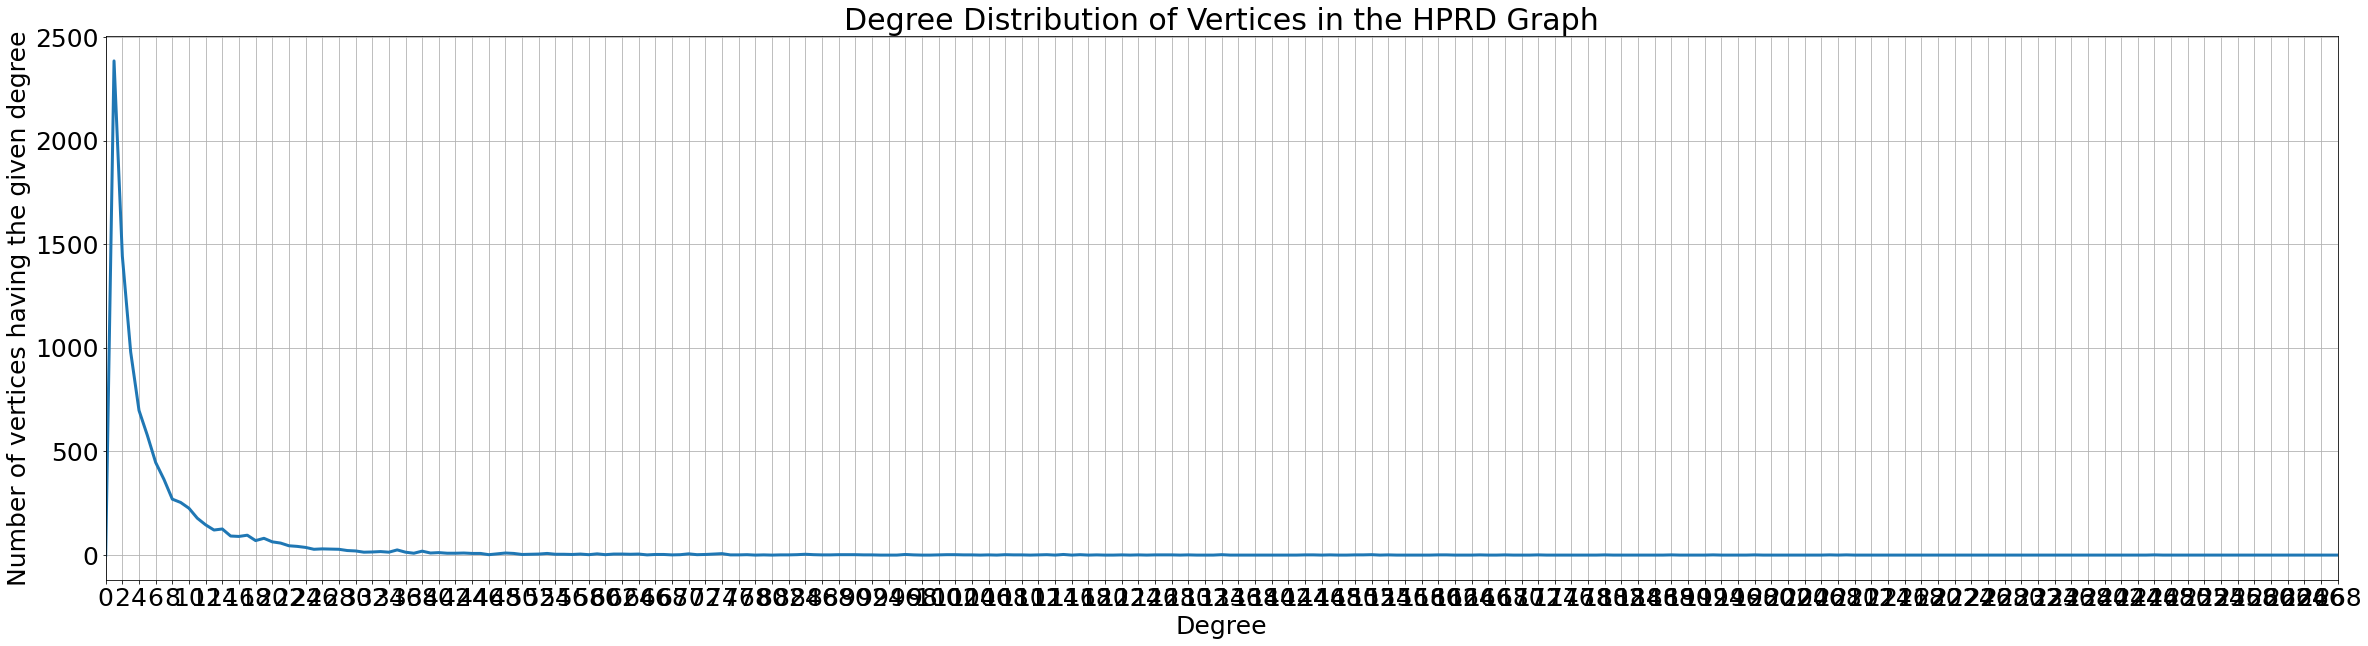

<Figure size 432x288 with 0 Axes>

In [183]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(270)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))

plt.figure(figsize=(40,10))
plt.plot(x, degree_counts, linewidth=3.0)
plt.ylabel('Number of vertices having the given degree')
plt.xlabel('Degree')
plt.title('Degree Distribution of Vertices in the HPRD Graph')

plt.xlim(0,100)
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.grid(True)
plt.savefig('degree_distribution.png', bbox_inches='tight')
plt.show()
plt.draw()

In [184]:
print("Diameter of the graph:", g.diameter())

# Source: https://snipplr.com/view/9914

def assortativity(graph, degrees=None):
    if degrees is None: degrees = graph.degree()
    degrees_sq = [deg**2 for deg in degrees]
 
    m = float(graph.ecount())
    num1, num2, den1 = 0, 0, 0
    for source, target in graph.get_edgelist():
        num1 += degrees[source] * degrees[target]
        num2 += degrees[source] + degrees[target]
        den1 += degrees_sq[source] + degrees_sq[target]
 
    num1 /= m
    den1 /= 2*m
    num2 = (num2 / (2*m)) ** 2
 
    return (num1 - num2) / (den1 - num2)

print("Assortativity of the graph:", assortativity(g))

Diameter of the graph: 14
Assortativity of the graph: -0.036095034666932896


In [195]:
betweenness = g.betweenness()

In [196]:
closeness = g.closeness(normalized=False)

In [197]:
degree = g.degree()

In [198]:
clustering_coefficient = g.transitivity_local_undirected(mode='zero')

In [199]:
named_vertex_list = g.vs()["name"]

In [200]:
features = {'Gene': named_vertex_list, 'betweenness': betweenness, 'closeness': closeness, 'degree': degree, 'clustering_coefficient': clustering_coefficient}

features_HPRD = pd.DataFrame(data = features)

features_HPRD

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.000000,1.000000,1,0.000000
1,A1CF,1085.665471,0.000024,5,0.100000
2,A2M,93280.103777,0.000029,28,0.010582
3,AAGAB,194.287629,0.000026,2,0.000000
4,AAMP,0.000000,0.000023,1,0.000000
...,...,...,...,...,...
9439,ZWINT,1609.260504,0.000023,4,0.333333
9440,ZXDC,47.097132,0.000025,3,0.000000
9441,ZYG11B,0.000000,0.000022,2,1.000000
9442,ZYX,14005.131007,0.000030,15,0.038095


In [201]:
features_HPRD_num = features_HPRD.select_dtypes(include='number')

In [202]:
normalized_HPRD = (features_HPRD_num-features_HPRD_num.min())/(features_HPRD_num.max()-features_HPRD_num.min())

features_HPRD[normalized_HPRD.columns] = normalized_HPRD

features_HPRD

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.000000,1.000000,0.000000,0.000000
1,A1CF,0.000529,0.000012,0.014925,0.100000
2,A2M,0.045448,0.000018,0.100746,0.010582
3,AAGAB,0.000095,0.000014,0.003731,0.000000
4,AAMP,0.000000,0.000012,0.000000,0.000000
...,...,...,...,...,...
9439,ZWINT,0.000784,0.000012,0.011194,0.333333
9440,ZXDC,0.000023,0.000014,0.007463,0.000000
9441,ZYG11B,0.000000,0.000011,0.003731,1.000000
9442,ZYX,0.006824,0.000018,0.052239,0.038095


In [203]:
features_HPRD.to_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/features_das_redes/features_HPRD.tsv', sep='\t')

## Rede IRefIndex

In [204]:
IRefIndex_network = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/networks/IREF_network3.tsv', sep = '\t')

IRefIndex_network = IRefIndex_network.drop(columns=['Unnamed: 0'])

IRefIndex_network

,gene1,gene2
0,AR,RNF14
1,RNF14,TCF3
2,RNF14,UBE2E1
3,RNF14,UBE2D4
4,RNF14,UBE2D3
...,...,...
133095,SELL,VCAN
133096,SELP,VCAN
133097,CAND1,LDHD
133098,CAND1,LDHA


In [205]:
# Teste com a rede
# Adicionando novas propriedades com o Igraph

# Método de ler arquivo externo para o Igraph

from igraph import *

g = Graph.DataFrame(IRefIndex_network, directed=False)

In [206]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 14632
Number of edges: 133100
Density of the graph: 0.0012434557884109473


In [207]:
degrees = []
total = 0
n_vertices = g.vcount()

for n in range(n_vertices):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/n_vertices)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 18.193001640240567
Maximum degree: 7859
Vertex ID with the maximum degree: 13427


In [208]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(7860)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))


Degree having the maximum number of vertices: 1
Number of vertices having the most abundant degree: 2410


In [209]:
print("Diameter of the graph:", g.diameter())

# Source: https://snipplr.com/view/9914

def assortativity(graph, degrees=None):
    if degrees is None: degrees = graph.degree()
    degrees_sq = [deg**2 for deg in degrees]
 
    m = float(graph.ecount())
    num1, num2, den1 = 0, 0, 0
    for source, target in graph.get_edgelist():
        num1 += degrees[source] * degrees[target]
        num2 += degrees[source] + degrees[target]
        den1 += degrees_sq[source] + degrees_sq[target]
 
    num1 /= m
    den1 /= 2*m
    num2 = (num2 / (2*m)) ** 2
 
    return (num1 - num2) / (den1 - num2)

print("Assortativity of the graph:", assortativity(g))

Diameter of the graph: 9
Assortativity of the graph: -0.051576800596414306


In [210]:
betweenness = g.betweenness()

In [211]:
closeness = g.closeness(normalized=False)

In [212]:
degree = g.degree()

In [213]:
clustering_coefficient = g.transitivity_local_undirected(mode='zero')

In [214]:
named_vertex_list = g.vs()["name"]

In [215]:
features = {'Gene': named_vertex_list, 'betweenness': betweenness, 'closeness': closeness, 'degree': degree, 'clustering_coefficient': clustering_coefficient}

features_IRefIndex = pd.DataFrame(data = features)

features_IRefIndex

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,14950.627114,0.000021,10,0.022222
1,A1CF,609.936600,0.000021,8,0.035714
2,A2M,80088.106770,0.000024,95,0.034938
3,AAAS,175.276561,0.000021,3,0.000000
4,AACS,240.760526,0.000027,2,0.000000
...,...,...,...,...,...
14627,ZYG11A,0.000000,0.000027,1,0.000000
14628,ZYG11B,569.787893,0.000027,7,0.571429
14629,ZYX,41442.789394,0.000028,70,0.081573
14630,ZZEF1,3368.011727,0.000027,12,0.136364


In [216]:
features_IRefIndex_num = features_IRefIndex.select_dtypes(include='number')

In [217]:
normalized_IRefIndex = (features_IRefIndex_num-features_IRefIndex_num.min())/(features_IRefIndex_num.max()-features_IRefIndex_num.min())

features_IRefIndex[normalized_IRefIndex.columns] = normalized_IRefIndex

features_IRefIndex

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.000209,0.000011,0.001145,0.022222
1,A1CF,0.000009,0.000010,0.000891,0.035714
2,A2M,0.001120,0.000013,0.011962,0.034938
3,AAAS,0.000002,0.000010,0.000255,0.000000
4,AACS,0.000003,0.000016,0.000127,0.000000
...,...,...,...,...,...
14627,ZYG11A,0.000000,0.000016,0.000000,0.000000
14628,ZYG11B,0.000008,0.000016,0.000764,0.571429
14629,ZYX,0.000580,0.000017,0.008781,0.081573
14630,ZZEF1,0.000047,0.000016,0.001400,0.136364


In [218]:
features_IRefIndex.to_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/features_das_redes/features_IRefIndex.tsv', sep='\t')

## Rede MultiNet

In [219]:
MultiNet_network = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/networks/MULTINET_network3.tsv', sep = '\t')

MultiNet_network = MultiNet_network.drop(columns=['Unnamed: 0'])

MultiNet_network

,gene1,gene2
0,RNF14,VDR
1,ACVR1,RNF14
2,DYRK2,RNF14
3,RNF14,UBE2E1
4,RNF14,UBE2D4
...,...,...
108563,LDHB,LDHD
108564,LDHC,LDHD
108565,LDHA,LDHB
108566,LDHA,LDHC


In [220]:
# Teste com a rede
# Adicionando novas propriedades com o Igraph

# Método de ler arquivo externo para o Igraph

from igraph import *

g = Graph.DataFrame(MultiNet_network, directed=False)

In [221]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 13987
Number of edges: 108568
Density of the graph: 0.0011099763727203493


In [222]:
degrees = []
total = 0
n_vertices = g.vcount()

for n in range(n_vertices):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/n_vertices)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 15.524129548866805
Maximum degree: 1494
Vertex ID with the maximum degree: 12847


In [223]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(1497)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))


Degree having the maximum number of vertices: 1
Number of vertices having the most abundant degree: 2783


In [224]:
print("Diameter of the graph:", g.diameter())

# Source: https://snipplr.com/view/9914

def assortativity(graph, degrees=None):
    if degrees is None: degrees = graph.degree()
    degrees_sq = [deg**2 for deg in degrees]
 
    m = float(graph.ecount())
    num1, num2, den1 = 0, 0, 0
    for source, target in graph.get_edgelist():
        num1 += degrees[source] * degrees[target]
        num2 += degrees[source] + degrees[target]
        den1 += degrees_sq[source] + degrees_sq[target]
 
    num1 /= m
    den1 /= 2*m
    num2 = (num2 / (2*m)) ** 2
 
    return (num1 - num2) / (den1 - num2)

print("Assortativity of the graph:", assortativity(g))

Diameter of the graph: 9
Assortativity of the graph: -0.1860397796835122


In [225]:
betweenness = g.betweenness()

In [226]:
closeness = g.closeness(normalized=False)

In [227]:
degree = g.degree()

In [228]:
clustering_coefficient = g.transitivity_local_undirected(mode='zero')

In [229]:
named_vertex_list = g.vs()["name"]

In [230]:
features = {'Gene': named_vertex_list, 'betweenness': betweenness, 'closeness': closeness, 'degree': degree, 'clustering_coefficient': clustering_coefficient}

features_MultiNet = pd.DataFrame(data = features)

features_MultiNet

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.000000,1.000000,1,0.000000
1,A1CF,13991.165081,0.000019,5,0.100000
2,A2M,29383.925891,0.000023,20,0.036842
3,AAAS,690.777544,0.000022,2,0.000000
4,AACS,121.853872,0.000020,14,0.670330
...,...,...,...,...,...
13982,ZXDC,6.240442,0.000020,3,0.000000
13983,ZYG11B,0.000000,0.000019,1,0.000000
13984,ZYX,58643.466095,0.000026,147,0.063554
13985,ZZEF1,64.776437,0.000018,3,0.000000


In [233]:
features_MultiNet_num = features_MultiNet.select_dtypes(include='number')

In [234]:
normalized_MultiNet = (features_MultiNet_num-features_MultiNet_num.min())/(features_MultiNet_num.max()-features_MultiNet_num.min())

features_MultiNet[normalized_MultiNet.columns] = normalized_MultiNet

features_MultiNet

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.000000e+00,1.000000,0.000000,0.000000
1,A1CF,1.253962e-03,0.000008,0.002679,0.100000
2,A2M,2.633543e-03,0.000011,0.012726,0.036842
3,AAAS,6.191113e-05,0.000010,0.000670,0.000000
4,AACS,1.092119e-05,0.000008,0.008707,0.670330
...,...,...,...,...,...
13982,ZXDC,5.593014e-07,0.000008,0.001340,0.000000
13983,ZYG11B,0.000000e+00,0.000007,0.000000,0.000000
13984,ZYX,5.255937e-03,0.000014,0.097790,0.063554
13985,ZZEF1,5.805607e-06,0.000006,0.001340,0.000000


In [235]:
features_MultiNet.to_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/features_das_redes/features_MultiNet.tsv', sep='\t')

## Rede STRING

In [236]:
STRING_network = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/networks/STRING_network3.tsv', sep = '\t')

STRING_network = STRING_network.drop(columns=['Unnamed: 0'])

STRING_network

,gene1,gene2
0,RNF14,UBE2Q1
1,RNF14,UBE2Q2
2,RNF11,RNF14
3,PPP3R1,RNF14
4,HSPA4,RNF14
...,...,...
5028704,SLC7A13,SLC7A14
5028705,SELE,SELP
5028706,SLC7A10,SLC7A13
5028707,SLC7A11,SLC7A13


In [237]:
# Teste com a rede
# Adicionando novas propriedades com o Igraph

# Método de ler arquivo externo para o Igraph

from igraph import *

g = Graph.DataFrame(STRING_network, directed=False)

In [238]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 18044
Number of edges: 5028709
Density of the graph: 0.030891922229235064


In [239]:
degrees = []
total = 0
n_vertices = g.vcount()

for n in range(n_vertices):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/n_vertices)
print("Maximum degree:", max(degrees))
print("Vertex ID with the maximum degree:", degrees.index(max(degrees)))

Average degree: 557.3829527820882
Maximum degree: 7536
Vertex ID with the maximum degree: 12003


In [240]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(7566)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))


Degree having the maximum number of vertices: 44
Number of vertices having the most abundant degree: 63


In [241]:
print("Diameter of the graph:", g.diameter())

# Source: https://snipplr.com/view/9914

def assortativity(graph, degrees=None):
    if degrees is None: degrees = graph.degree()
    degrees_sq = [deg**2 for deg in degrees]
 
    m = float(graph.ecount())
    num1, num2, den1 = 0, 0, 0
    for source, target in graph.get_edgelist():
        num1 += degrees[source] * degrees[target]
        num2 += degrees[source] + degrees[target]
        den1 += degrees_sq[source] + degrees_sq[target]
 
    num1 /= m
    den1 /= 2*m
    num2 = (num2 / (2*m)) ** 2
 
    return (num1 - num2) / (den1 - num2)

print("Assortativity of the graph:", assortativity(g))

Diameter of the graph: 5
Assortativity of the graph: 0.0849376023175792


In [242]:
betweenness = g.betweenness()

In [243]:
closeness = g.closeness(normalized=False)

In [244]:
degree = g.degree()

In [245]:
clustering_coefficient = g.transitivity_local_undirected(mode='zero')

In [246]:
named_vertex_list = g.vs()["name"]

In [247]:
features = {'Gene': named_vertex_list, 'betweenness': betweenness, 'closeness': closeness, 'degree': degree, 'clustering_coefficient': clustering_coefficient}

features_STRING = pd.DataFrame(data = features)

features_STRING

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,5284.065580,0.000026,428,0.374335
1,A1CF,968.945346,0.000025,123,0.216980
2,A2M,7910.000608,0.000027,538,0.274020
3,A2ML1,3636.554649,0.000024,140,0.170606
4,A4GALT,767.526090,0.000025,75,0.179099
...,...,...,...,...,...
18039,ZYG11A,177.286707,0.000022,49,0.380102
18040,ZYG11B,618.233638,0.000023,66,0.265268
18041,ZYX,8210.880281,0.000027,504,0.264248
18042,ZZEF1,14433.134024,0.000027,810,0.483496


In [248]:
features_STRING_num = features_STRING.select_dtypes(include='number')

In [249]:
normalized_STRING = (features_STRING_num-features_STRING_num.min())/(features_STRING_num.max()-features_STRING_num.min())

features_STRING[normalized_STRING.columns] = normalized_STRING

features_STRING

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.002394,0.574926,0.056669,0.374335
1,A1CF,0.000439,0.491816,0.016191,0.216980
2,A2M,0.003584,0.595557,0.071267,0.274020
3,A2ML1,0.001648,0.451462,0.018447,0.170606
4,A4GALT,0.000348,0.482407,0.009821,0.179099
...,...,...,...,...,...
18039,ZYG11A,0.000080,0.354566,0.006370,0.380102
18040,ZYG11B,0.000280,0.406438,0.008626,0.265268
18041,ZYX,0.003720,0.608146,0.066755,0.264248
18042,ZZEF1,0.006540,0.622918,0.107366,0.483496


In [250]:
features_STRING.to_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/features_das_redes/features_STRING.tsv', sep='\t')

## UNITY Network

In [251]:
UNITY_network = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/networks/UNITY_network3.tsv', sep = '\t')

UNITY_network = UNITY_network.drop(columns=['Unnamed: 0'])

UNITY_network

,gene1,gene2
0,TMCO1,UBE2Q1
1,UBE2Q1,ZNF706
2,RNF115,UBE2Q1
3,METTL13,UBE2Q1
4,DHX8,UBE2Q1
...,...,...
7391447,SLC7A13,SLC7A14
7391448,SELE,SELP
7391449,SLC7A10,SLC7A13
7391450,SLC7A11,SLC7A13


In [252]:
from igraph import *

g = Graph.DataFrame(UNITY_network, directed=False)

In [253]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 19792
Number of edges: 7391452
Density of the graph: 0.03774003820931156


In [254]:
betweenness = g.betweenness()

In [255]:
closeness = g.closeness(normalized=False)

In [256]:
degree = g.degree()

In [257]:
clustering_coefficient = g.transitivity_local_undirected(mode='zero')

In [258]:
named_vertex_list = g.vs()["name"]

In [259]:
features = {'Gene': named_vertex_list, 'betweenness': betweenness, 'closeness': closeness, 'degree': degree, 'clustering_coefficient': clustering_coefficient}

features_UNITY = pd.DataFrame(data = features)

features_UNITY

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,2715.725958,0.000024,456,0.366879
1,A1CF,6912.205003,0.000024,436,0.157566
2,A2M,12065.713940,0.000025,924,0.215840
3,A2ML1,3717.131373,0.000024,353,0.360546
4,A3GALT2,0.000000,0.000016,2,1.000000
...,...,...,...,...,...
19787,ZYG11A,95.665565,0.000022,58,0.372656
19788,ZYG11B,1243.798868,0.000024,163,0.245172
19789,ZYX,31646.412236,0.000026,2152,0.357556
19790,ZZEF1,14430.180088,0.000025,962,0.381368


In [260]:
features_UNITY_num = features_UNITY.select_dtypes(include='number')

In [261]:
normalized_UNITY = (features_UNITY_num-features_UNITY_num.min())/(features_UNITY_num.max()-features_UNITY_num.min())

features_UNITY[normalized_UNITY.columns] = normalized_UNITY

features_UNITY

,Gene,betweenness,closeness,degree,clustering_coefficient
0,A1BG,0.000453,0.000012,0.042251,0.366879
1,A1CF,0.001153,0.000012,0.040394,0.157566
2,A2M,0.002013,0.000013,0.085709,0.215840
3,A2ML1,0.000620,0.000012,0.032686,0.360546
4,A3GALT2,0.000000,0.000004,0.000093,1.000000
...,...,...,...,...,...
19787,ZYG11A,0.000016,0.000010,0.005293,0.372656
19788,ZYG11B,0.000208,0.000011,0.015043,0.245172
19789,ZYX,0.005280,0.000014,0.199740,0.357556
19790,ZZEF1,0.002407,0.000013,0.089238,0.381368


In [262]:
features_UNITY.to_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/features_das_redes/features_UNITY.tsv', sep='\t')